In [2]:
#!pip install fastbook

In [3]:
from fastbook import *
from fastai.vision.widgets import *

## Data Loading

NOTE: the book used **Microsoft bing** using Azure keys. But We are using **DuckDuckGo** for simplicity 

In [4]:
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return search_images_ddg(term, max_images)

### Getting Documenation

In [5]:
??search_images_ddg

Signature: search_images_ddg(term, max_images=200)
Source:   
def search_images_ddg(term, max_images=200):
    "Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images"
    assert max_images<1000
    url = 'https://duckduckgo.com/'
    res = urlread(url,data={'q':term})
    searchObj = re.search(r'vqd=([\d-]+)\&', res)
    assert searchObj
    requestUrl = url + 'i.js'
    params = dict(l='us-en', o='json', q=term, vqd=searchObj.group(1), f=',,,', p='1', v7exp='a')
    urls,data = set(),{'next':1}
    headers = dict(referer='https://duckduckgo.com/')
    while len(urls)<max_images and 'next' in data:
        try:
            res = urlread(requestUrl, data=params, headers=headers)
            data = json.loads(res) if res else {}
            urls.update(L(data['results']).itemgot('image'))
            requestUrl = url + data['next']
        except (URLError,HTTPError): pass
        time.sleep(1)
    return L(urls)[:max_images]
File:      /opt/conda/lib/py

In [8]:
?search_images_ddg

Signature: search_images_ddg(term, max_images=200)
Docstring: Search for `term` with DuckDuckGo and return a unique urls of about `max_images` images
File:      /opt/conda/lib/python3.11/site-packages/fastbook/__init__.py
Type:      function

In [9]:
search_images_ddg

<function fastbook.search_images_ddg(term, max_images=200)>

### Collect Data

Searching for 'grizzly bear'


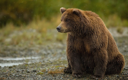

In [11]:
results = search_images_ddg('grizzly bear')
len(results)

urls = search_images('grizzly bear',max_images=1)
urls[0]

dest= 'images/grizzly.jpg'
download_url(urls[0], dest, show_progress=True)

im = Image.open(dest)
im.to_thumb(128,128)


In [13]:
bear_types = 'grizzly','black','teddy'
path= Path('bears')

In [ ]:
if not path.exists():
    path.mkdir()
    
for o in bear_types: # This should be outside the if statement 
    dest = (path/o)
    dest.mkdir(exist_ok=True)
    results = search_images_ddg(f'{o} bear')
    download_images(dest, urls=results)

In [14]:
fns = get_image_files(path)

In [15]:
fns

(#545) [Path('bears/black/0099ce30-20e2-4eb0-af40-ee2fdd2488b1.jpg'),Path('bears/black/0136701e-b25b-4b3a-8532-d06af4af9179.jpg'),Path('bears/black/016af27f-a632-4093-a591-19f1e073c026.jpg'),Path('bears/black/0204ddee-d5cb-4ae4-973b-251dae59d7ee.JPG'),Path('bears/black/03192fad-f630-45ed-962b-ab4650ec7f06.jpg'),Path('bears/black/0443b871-9ae5-4bbc-a6e0-d77db41f3a9e.jpg'),Path('bears/black/04d5dccb-227e-4866-a366-aa42f5cd745e.jpg'),Path('bears/black/05feb55c-6305-4fa9-a2ce-1742ba63751a.jpg'),Path('bears/black/0684b2b2-2de3-4b7a-a081-ab37ae0f253f.jpg'),Path('bears/black/068c2b3c-f4d6-43d1-97bd-ceffb5da36e9.JPG')...]

### Remove Unopenable Image 

In [16]:
failed = verify_images(fns)

In [17]:
failed

(#0) []

In [18]:
failed.map(Path.unlink)

(#0) []

In [78]:
fns

(#573) [Path('bears/black/0099ce30-20e2-4eb0-af40-ee2fdd2488b1.jpg'),Path('bears/black/0136701e-b25b-4b3a-8532-d06af4af9179.jpg'),Path('bears/black/016af27f-a632-4093-a591-19f1e073c026.jpg'),Path('bears/black/0204ddee-d5cb-4ae4-973b-251dae59d7ee.JPG'),Path('bears/black/03192fad-f630-45ed-962b-ab4650ec7f06.jpg'),Path('bears/black/0443b871-9ae5-4bbc-a6e0-d77db41f3a9e.jpg'),Path('bears/black/04d5dccb-227e-4866-a366-aa42f5cd745e.jpg'),Path('bears/black/05feb55c-6305-4fa9-a2ce-1742ba63751a.jpg'),Path('bears/black/0684b2b2-2de3-4b7a-a081-ab37ae0f253f.jpg'),Path('bears/black/068c2b3c-f4d6-43d1-97bd-ceffb5da36e9.JPG')...]

In [19]:
??verify_images

Signature: verify_images(fns)
Source:   
def verify_images(fns):
    "Find images in `fns` that can't be opened"
    return L(fns[i] for i,o in enumerate(parallel(verify_image, fns)) if not o)
File:      /opt/conda/lib/python3.11/site-packages/fastai/vision/utils.py
Type:      function

In [20]:
doc(verify_images)

### Train your model before cleaning up

In [21]:
bears = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [22]:
dls = bears.dataloaders(path) 

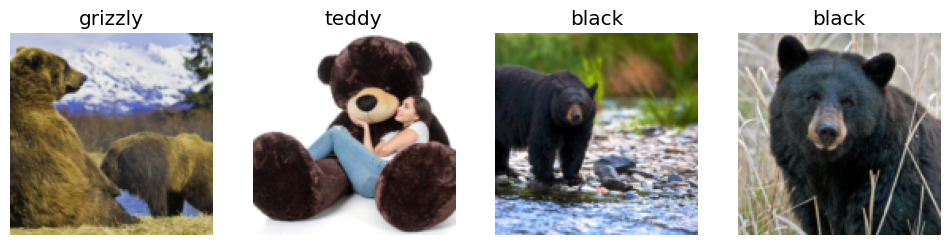

In [23]:
dls.valid.show_batch(max_n=4, nrows=1)

#### Different Ways Of Resizing

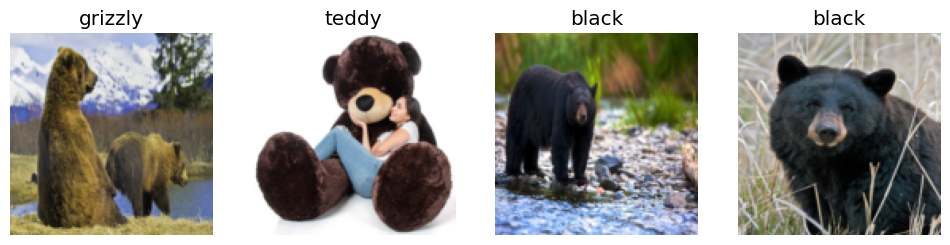

In [24]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

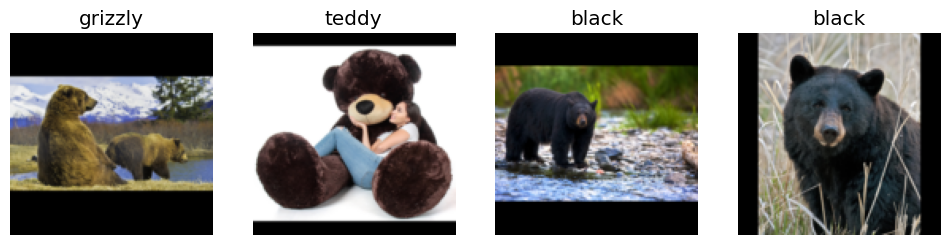

In [25]:
bears = bears.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = bears.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

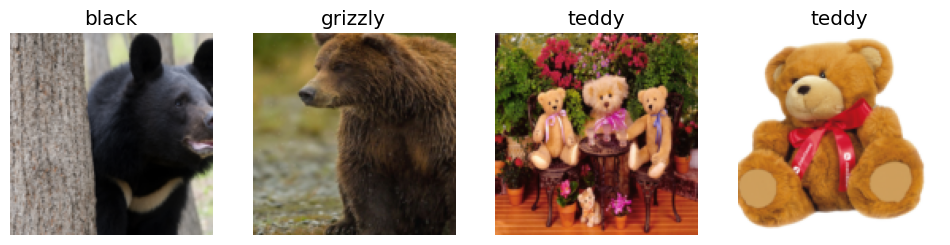

In [27]:
bears = bears.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1)

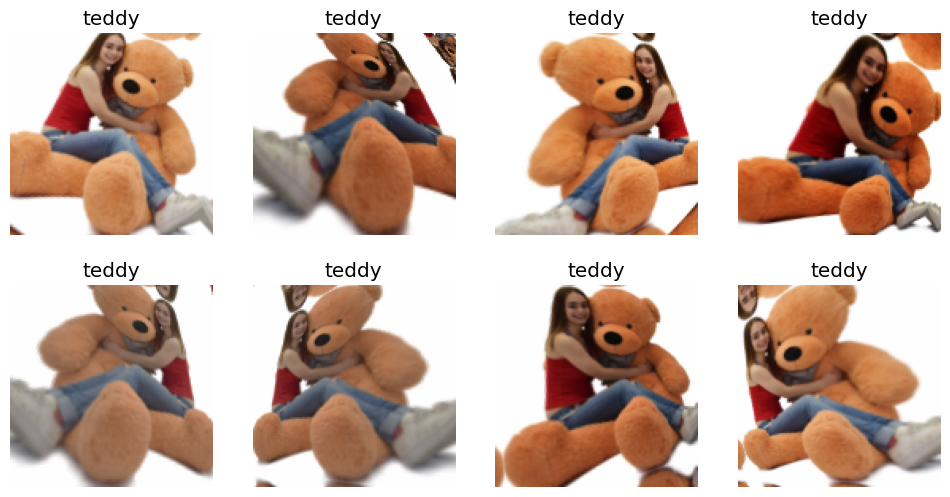

In [95]:
bears = bears.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = bears.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=2, unique=True)

## Training Your Model, and Using It to Clean Your data

In [28]:
bears = bears.new(
    item_tfms=RandomResizedCrop(128, min_scale=0.5),
    batch_tfms=aug_transforms()
)
dls = bears.dataloaders(path)

In [29]:
learn = vision_learner(dls, resnet18, metrics=error_rate)

In [30]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.390750,0.379923,0.073394,00:23


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.449676,0.267200,0.055046,00:29
1,0.310859,0.326334,0.055046,00:28
2,0.273432,0.332126,0.045872,00:30
3,0.228987,0.309142,0.045872,00:30


/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/lib/python3.11/site-packages/PIL/Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [ ]:
Cla